In [29]:

import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os
from qutip import*
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap as lsc
import time
from matplotlib.pyplot import figure, show
from matplotlib import gridspec
from tqdm.auto import tqdm # progress bar
from scipy.optimize import curve_fit
from tcsim.system import*
from tcsim.visualization import*

from function import*

In [35]:
def load_data_no_average(path: str, file_end: str,thresh, plot = True): 
    """_summary_

    Args:
        path (str): folder where files are located
        file_end (str): ending of files to load
        
    Returns:
        dd (dict): keys are time stamps and value is a non averaged data set of size (number of total reps, x, y)
    """
    fps = []
    fp = [path + f for f in os.listdir(path) if f.endswith(file_end)]
    fps = np.concatenate([fp[:]])
    
    dg = []
    de = []
    dts = []
    for kk in range(len(fps)):
        df = h5py.File(fps[kk], "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0, 0]
        y = data["y"][0, :, 0]
        dt = df.attrs['decay_time']
#         ss_data = np.where(data_i < thresh, 1, 0)
#         thresh_1 = 6.30337300715842e-05
        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]
        
        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)
        ## I only care about the double selected data!
        ## I use filled to replace all masked arrays with nan. This allows me to not care about masks after this point. This is useful, as i can later use np.nanmean to calculate the mean value.
        double_ps_g = ma.masked_array(m2_g, mask=m1_g, dtype='float').filled(np.nan).reshape(df.attrs["reps"],len(x), len(y)) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g), dtype='float').filled(np.nan).reshape(df.attrs["reps"], len(x), len(y)) * 2 - 1
        dg.append(double_ps_g)
        de.append(double_ps_e)
        dts.append(dt)

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)

    
    dd = {}
    # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            dd[str(decay_times[n])] = []

    # use dts to sort the values by decay time into the correct bin
    for n, dt in enumerate(dts):
        dd[str(dt)].append(dg[n])
      
    # stack all arrays that were in the list
    for dt in decay_times:
        dd[str(dt)] = np.vstack(np.array(dd[str(dt)]))
    
    rows = 1
    cols = len(decay_times)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
    # for i in range(rows):
    for j in range(cols):
        
        axes[j].pcolormesh(x, x, np.nanmean(dd[str(decay_times[j])][:, :], axis = 0), cmap="seismic", shading = 'auto', vmax=1, vmin=-1)
        axes[j].set_aspect("equal")
        axes[j].set_title(str(decay_times[j]))     
    plt.show()
         
    plt.show()
    return dd, decay_times, x, y

def bootstrap_resample(X):
    n = shape(X)[0]
    X_resample = np.zeros_like(X.T)
    XT = X.T.copy()

    resample_i = np.floor(np.random.rand(n)*n).astype(int)
    for x in range(shape(X)[1]):
        for y in range(shape(X)[2]):
                      
                X_resample[:][y][x] = XT[y][x][resample_i]
    return X_resample.T

def find_averaged_parity_and_errorbars(decay_times, paritys):
    paritys_averaged = []
    error_bars = []
    for time in decay_times:
        parity_avg = np.array(paritys[str(time)])
    
        paritys_averaged.append(np.mean(parity_avg))
        error_bars.append(np.std(parity_avg))
    return paritys_averaged, error_bars

def get_parity_from_charfunc(char_func, dx, scale, padding=True, pad_n=201):
    f, wig = wigner_from_char(char_func, dx, scale, padding, pad_n)
    parity = np.real(wig[pad_n//2, pad_n//2])*np.pi/2
    return parity

def extract_parity(dd, decay_times, x, n_reps, plot=False,):
    
    
    paritys = {}
    for n in range(len(decay_times)):
            paritys[str(decay_times[n])] = []
    
    for rep in range(n_reps):
        ### 0. resample data and saved resampled data in new dictionary
        dd_bt = {}
        for j in range(len(decay_times)):
            dd_bt[str(decay_times[j])] = bootstrap_resample(dd[str(decay_times[j])])
        data_dict = dd_bt
        print("Run Number:", rep)
        
        for i, time in enumerate(decay_times):
            
            scaling = 3
            data = np.nanmean(data_dict[str(time)], axis = 0)
            
            parity = get_parity_from_charfunc(data, x[1]-x[0], 3)
            
            paritys[str(time)].append(parity)

    return paritys

def find_averaged_parity_and_errorbars(decay_times, paritys):
    paritys_averaged = []
    error_bars = []
    for time in decay_times:
        parity_avg = np.array(paritys[str(time)])
    
        paritys_averaged.append(np.mean(parity_avg))
        error_bars.append(np.std(parity_avg))
    return paritys_averaged, error_bars
    

## normal cat

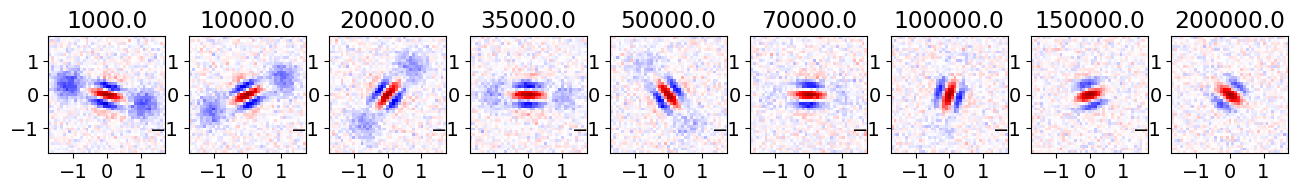

In [38]:
# normal cats
#vac_norm = 0.883
thresh = 0.00017
filename = 'normal_cat_decay_loop_oddcat.h5'

d= "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/data_parity/odd_cat_decay/"

data, decay_times, x, y = load_data_no_average(d,filename, thresh = thresh, plot = True)

# data_norm =list(data.values())[0]/vac_norm

In [36]:
data_mean = np.nanmean(data["1000.0"], axis = 0)
data_mean[:,:5].mean()

-0.028003064422853753

Run Number: 0
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
Run Number: 11
Run Number: 12
Run Number: 13
Run Number: 14


Text(0, 0.5, 'Side Blob Amp')

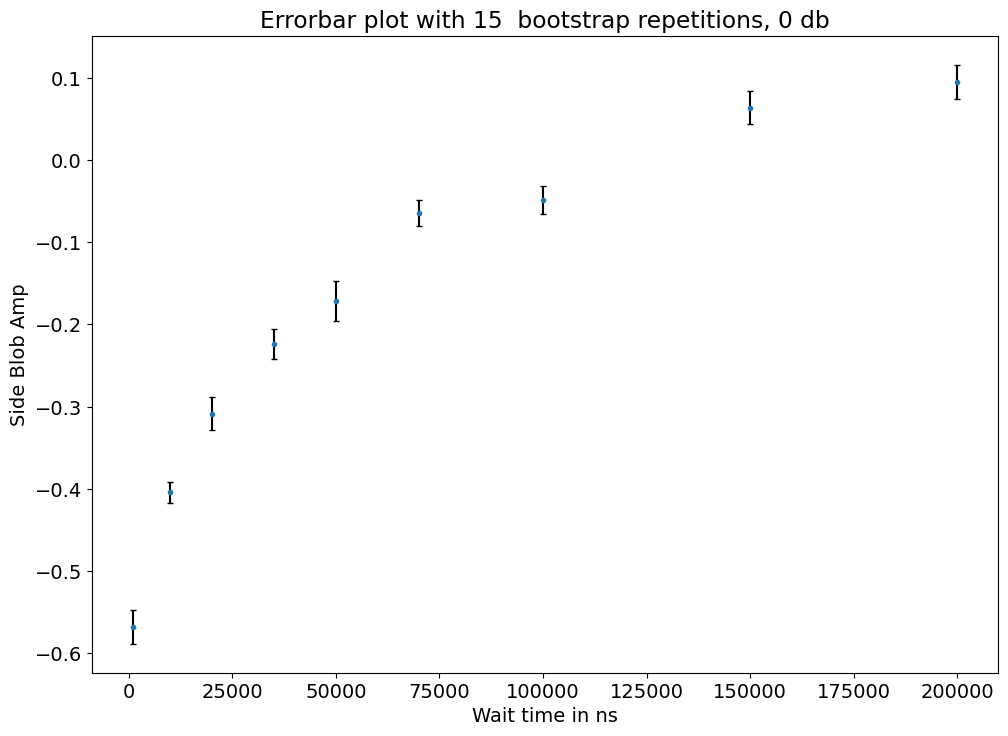

In [39]:
reps = 15

paritys = extract_parity(data,decay_times, x, reps)

paritys_averaged_0, error_bars_0 = find_averaged_parity_and_errorbars(decay_times, paritys)
plt.errorbar(decay_times[:], paritys_averaged_0[:],yerr=error_bars_0,fmt= '.', ecolor = 'k', capsize = 2)

plt.title(f'Errorbar plot with {reps}  bootstrap repetitions, 0 db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")

### 3 db

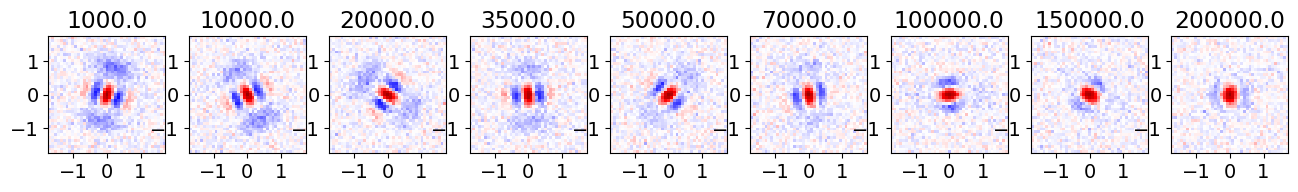

In [58]:
# normal cats
#vac_norm = 0.883
thresh = 0.000203
filename = 'sq_vcat_3db_oddcat.h5'

d= "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/data_parity/3db/"

data, decay_times, x, y = load_data_no_average(d,filename, thresh = thresh, plot = True)

# data_norm =list(data.values())[0]/vac_norm

Run Number: 0
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
Run Number: 11
Run Number: 12
Run Number: 13
Run Number: 14
Run Number: 15
Run Number: 16
Run Number: 17
Run Number: 18
Run Number: 19
Run Number: 20
Run Number: 21
Run Number: 22
Run Number: 23
Run Number: 24
Run Number: 25
Run Number: 26
Run Number: 27
Run Number: 28
Run Number: 29
Run Number: 30
Run Number: 31
Run Number: 32
Run Number: 33
Run Number: 34
Run Number: 35
Run Number: 36
Run Number: 37
Run Number: 38
Run Number: 39
Run Number: 40
Run Number: 41
Run Number: 42
Run Number: 43
Run Number: 44
Run Number: 45
Run Number: 46
Run Number: 47
Run Number: 48
Run Number: 49


Text(0, 0.5, 'Side Blob Amp')

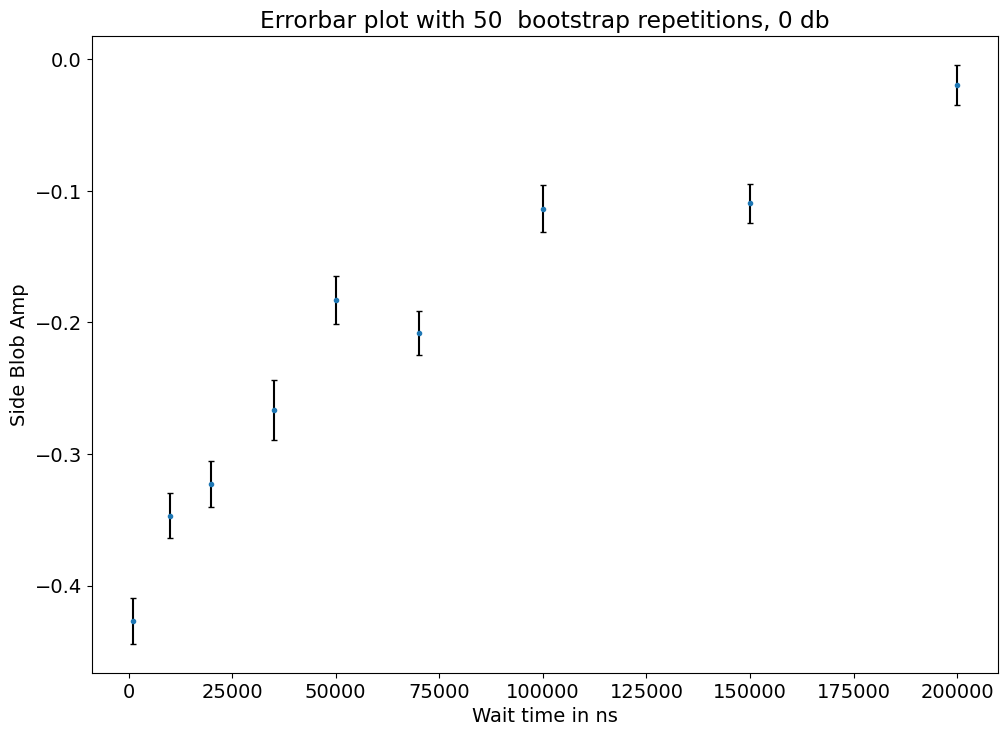

In [60]:
reps = 50

paritys = extract_parity(data,decay_times, x, reps)

paritys_averaged_3, error_bars_3 = find_averaged_parity_and_errorbars(decay_times, paritys)
plt.errorbar(decay_times[:], paritys_averaged_3[:],yerr=error_bars_3,fmt= '.', ecolor = 'k', capsize = 2)

plt.title(f'Errorbar plot with {reps}  bootstrap repetitions, 0 db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")

### 7dB

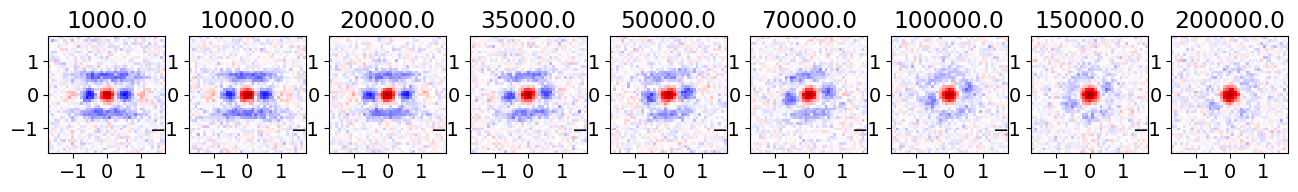

In [61]:
# normal cats
#vac_norm = 0.883
thresh = 0.0001827
filename = 'panther_sq_vcat_7db_oddcat.h5'

d= "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/data_parity/7db/"

data, decay_times, x, y = load_data_no_average(d,filename, thresh = thresh, plot = True)

# data_norm =list(data.values())[0]/vac_norm

Run Number: 0
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
Run Number: 11
Run Number: 12
Run Number: 13
Run Number: 14
Run Number: 15
Run Number: 16
Run Number: 17
Run Number: 18
Run Number: 19
Run Number: 20
Run Number: 21
Run Number: 22
Run Number: 23
Run Number: 24
Run Number: 25
Run Number: 26
Run Number: 27
Run Number: 28
Run Number: 29
Run Number: 30
Run Number: 31
Run Number: 32
Run Number: 33
Run Number: 34
Run Number: 35
Run Number: 36
Run Number: 37
Run Number: 38
Run Number: 39
Run Number: 40
Run Number: 41
Run Number: 42
Run Number: 43
Run Number: 44
Run Number: 45
Run Number: 46
Run Number: 47
Run Number: 48
Run Number: 49


Text(0, 0.5, 'Side Blob Amp')

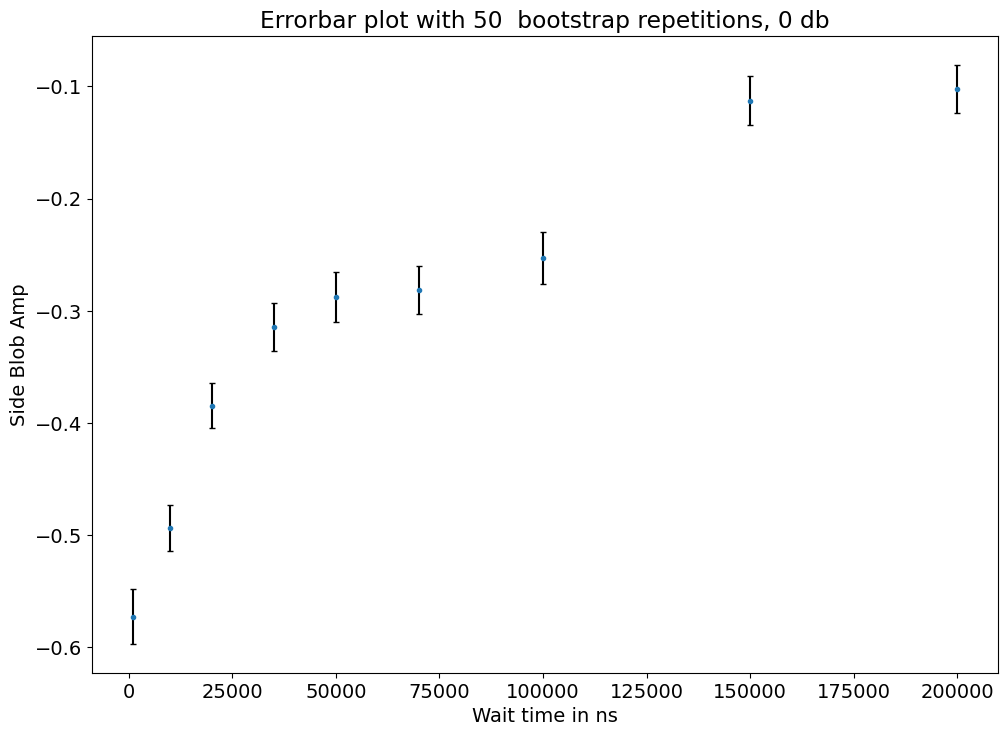

In [62]:
reps = 50

paritys = extract_parity(data,decay_times, x, reps)

paritys_averaged_7, error_bars_7 = find_averaged_parity_and_errorbars(decay_times, paritys)
plt.errorbar(decay_times[:], paritys_averaged_7[:],yerr=error_bars_7,fmt= '.', ecolor = 'k', capsize = 2)

plt.title(f'Errorbar plot with {reps}  bootstrap repetitions, 0 db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")

In [64]:
np.savez("paritys_with_error",paritys_averaged_0 = paritys_averaged_0, error_bars_0 = error_bars_0, paritys_averaged_3 = paritys_averaged_3, error_bars_3 = error_bars_3, paritys_averaged_7 = paritys_averaged_7, error_bars_7 = error_bars_7 )